In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

from helper_functions import find_outlier_games, kfold_validate_score, kfold_validate_pred, var_plot

In [2]:
# Import processed data from EDA notebook
bgg = pd.read_csv('./data/bgg_processed.csv', index_col='game_id')

In [3]:
# Split off target column: `avg_rating`
y = bgg['avg_rating']
X = bgg.drop('avg_rating', axis=1).copy()

In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Initial linear regression

First let's see how simple linear regression fares. There are 2000 entries in the original data, so the train/test split leaves 1600 rows in the training data. 8 splits for K-Fold cross validation should ve sufficient so each slice is 200 rows. The rows were already shuffled with the train/test split, so they don't need shuffled again.

In [37]:
# Find mean RMSE through linear regression over 8 folds
linear = LinearRegression().fit(X_train, y_train)

linear_rmse = kfold_validate_score(X_train, y_train, model=linear)
linear_rmse

0.2900673749246467

In [23]:
# Generate predictions from the cross validation
preds = kfold_validate_pred(X_train, y_train, model=linear)

# show the min and max predictions
print(f'Max prediction: {np.max(preds)}\nMin prediction: {np.min(preds)}')

Max prediction: 11.409906691914584
Min prediction: -2295571259637.283


In [25]:
preds_sort = np.sort(preds, axis=None)
preds_sort

array([-2.29557126e+12,  5.79988069e+00,  6.14916139e+00, ...,
        9.10099665e+00,  9.28477449e+00,  1.14099067e+01])

In [21]:
preds_sort

array([<built-in method sort of numpy.ndarray object at 0x7fd335b58f30>],
      dtype=object)

In [24]:
preds

array([7.18031593, 7.14230428, 6.73584719, ..., 7.52238108, 7.22286393,
       7.19165134])

## Lasso Regression

How do other methods of regression fare? First let's look at Lasso Regression:

In [26]:
# Find mean RMSE through lasso regression over 8 fold
lasso = LassoCV(random_state=42).fit(X_train, y_train)

lasso_rmse = kfold_validate_score(X_train, y_train, model=lasso)
lasso_rmse

0.30750968979087084

## Ridge Regression

In [27]:
# Find mean RMSE through ridge regression over 8 fold
ridge = RidgeCV().fit(X_train, y_train)

ridge_rmse = kfold_validate_score(X_train, y_train, model=ridge)
ridge_rmse

0.29690849801637825

## Principle Component Regression 

In [28]:
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

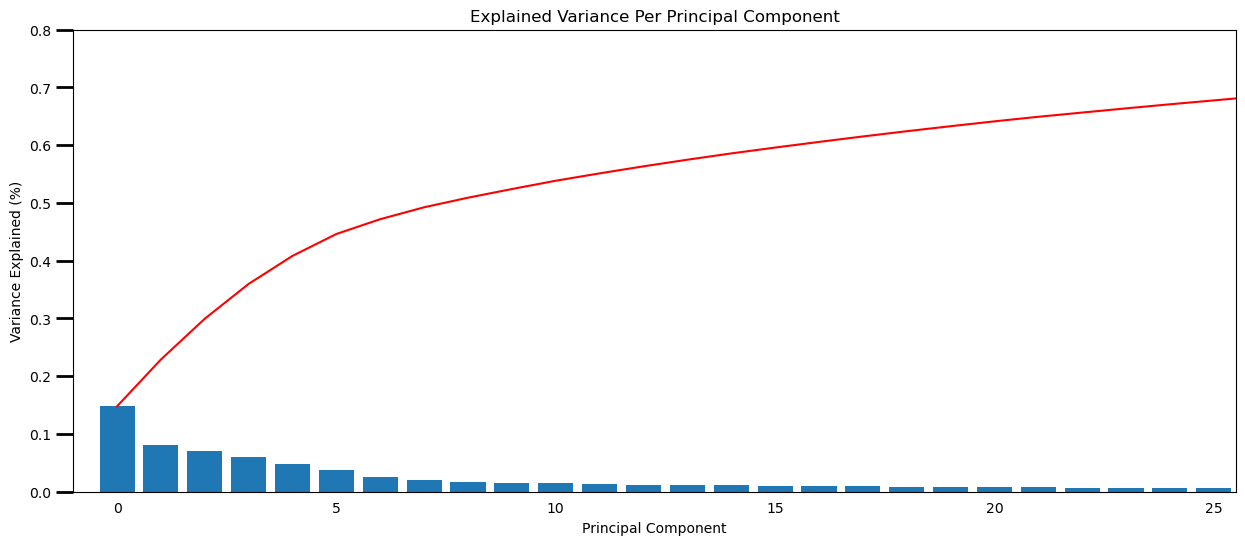

In [29]:
var_plot(pca)
plt.xlim(-1,25.5)
plt.ylim(0, 0.8);

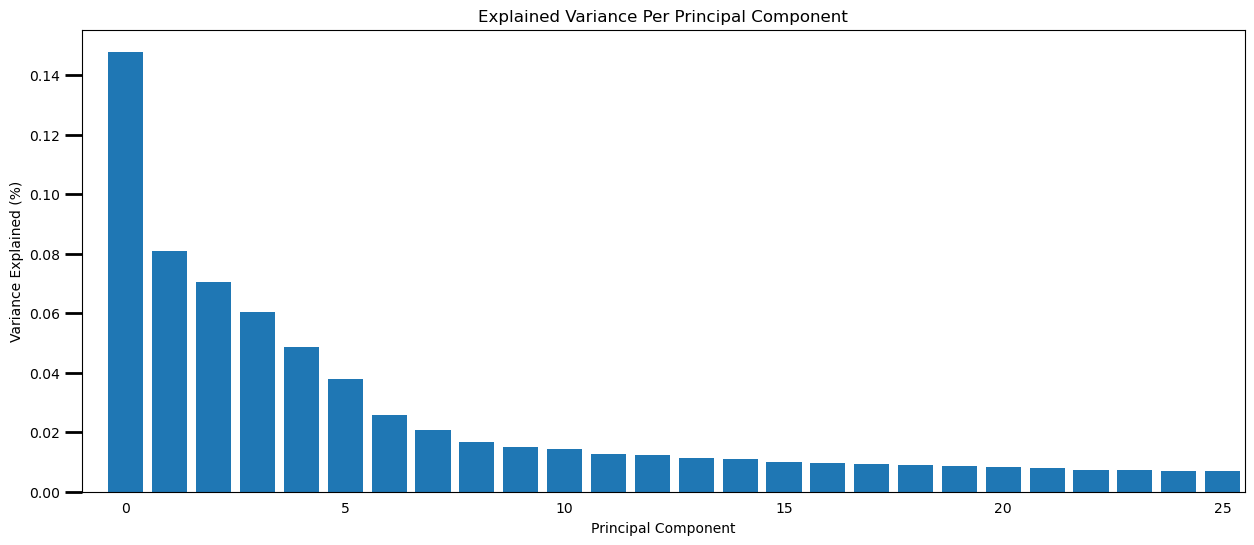

In [30]:
# Bar chart showing variance of PCA transformation with no paramaters
var_plot(pca, scree=False)

# Restrict the x-axis to allow a better view of the important data
plt.xlim(-1,25.5);

In [31]:
# Instatiate
pca_9 = PCA(9, random_state=42)

# Fit & Transform
X_train_reduced_9 = pca_9.fit_transform(X_train)

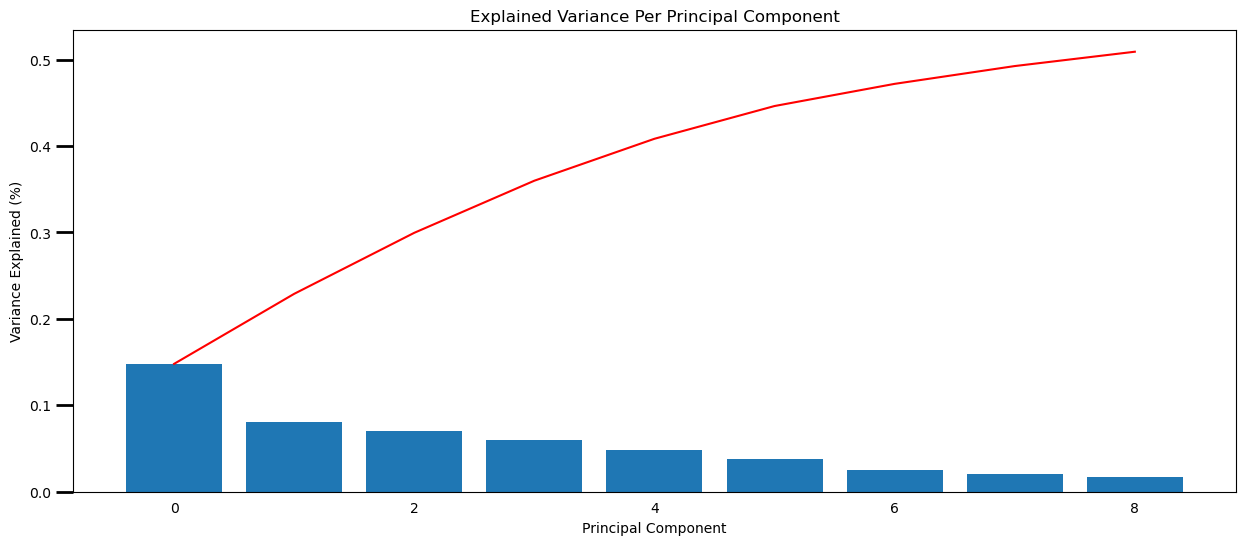

In [32]:
var_plot(pca_9)

In [33]:
# Total percentage of 9 principal components
pca_9.explained_variance_ratio_.sum()

0.5091366269665704

50% of the variance is explained by 9 PCA components.

In [50]:
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,258):
    linear_pca = LinearRegression().fit(X_reduced[:,:i], y_train)
    rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=linear_pca)
    pca_rmses.append(rmse)

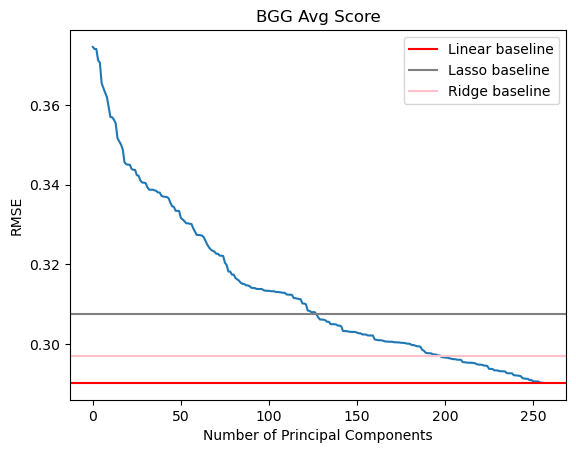

In [51]:
plt.plot(pca_rmses)

# add baselines
plt.axhline(linear_rmse, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [52]:
# Try it with Lasso regression
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,258):
    lasso_pca = LassoCV(random_state=42).fit(X_reduced[:,:i], y_train)
    rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=lasso_pca)
    pca_rmses.append(rmse)

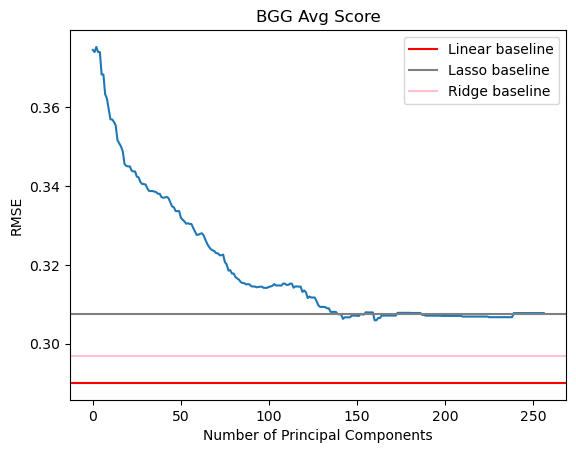

In [53]:
plt.plot(pca_rmses)

# add baselines
plt.axhline(linear_rmse, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [54]:
# Try it with Ridge regression
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,258):
    ridge_pca = RidgeCV().fit(X_reduced[:,:i], y_train)
    rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=ridge_pca)
    pca_rmses.append(rmse)

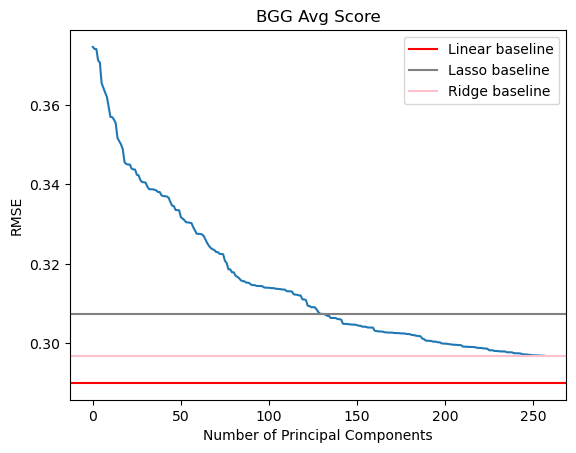

In [55]:
plt.plot(pca_rmses)

# add baselines
plt.axhline(linear_rmse, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

## Partial Least Squares Regression

In [56]:
pls = PLSRegression(n_components=10)
X_train_pls = pls.fit(X_train, y_train)

In [57]:
X_train_pls = pls.transform(X_train)

In [58]:
# Check mean RMSE for 10 PLS components
linear_pls = LinearRegression().fit(X_train_pls, y_train)

rmse_pls = kfold_validate_score(X_train_pls, y_train, model=linear_pls)
rmse_pls

0.2904510509768359

In [62]:
linear_pls_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,258):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)

    linear_pls = LinearRegression().fit(X_train_pls, y_train)
    
    rmse = kfold_validate_score(X_train_pls, y_train, model=linear_pls)
    
    linear_pls_rmses.append(rmse)

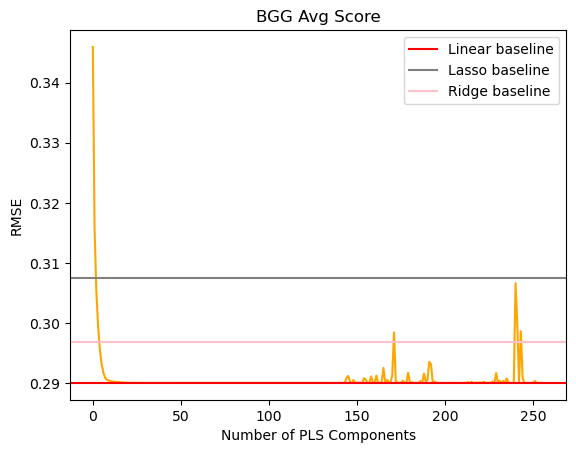

In [63]:
plt.plot(linear_pls_rmses, color='orange')

# add baselines
plt.axhline(linear_rmse, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

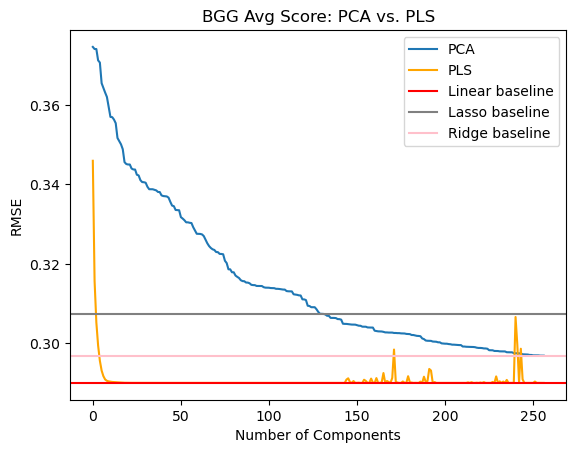

In [64]:
plt.plot(pca_rmses, label='PCA')
plt.plot(linear_pls_rmses, label='PLS', color='orange')

# add baselines
plt.axhline(linear_rmse, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score: PCA vs. PLS');